In [10]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from scipy.ndimage import gaussian_filter1d
from scipy.signal import iirnotch, filtfilt, butter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [38]:
raw_file_path = "raw_data.txt"
prepocessed_code_path = "codes.npy"
preprocessed_wave_path = "brainwaves.npy"
writer_path = os.path.join("runs", "EEG_classification")

# Reading data

In [2]:
with open(raw_file_path, "r") as file:
    lines = file.readlines()

# Extract codes (4th column) and brainwaves (7th column onward)
codes = []
brainwaves = []

for line in lines[1:]:  # Skip header
    parts = line.strip().split("\t")  # Assuming tab-separated values
    code = parts[4]  # 4th column (code)
    brainwave_values = list(map(float, parts[6:][0].split(',')))  # 7th column to end (brainwave signals)
    
    codes.append(int(code))
    brainwaves.append(brainwave_values)

In [ ]:
target_length = max(len(ts) for ts in brainwaves)  # Choose max length

# Function to interpolate a time series to the target length
def interpolate_timeseries(series, target_length):
    x_old = np.linspace(0, 1, len(series))  # Original time points
    x_new = np.linspace(0, 1, target_length)  # New time points
    return np.interp(x_new, x_old, series).tolist()

# Apply interpolation to each series
resampled_brainwaves = [interpolate_timeseries(ts, target_length) for ts in brainwaves]

print(resampled_brainwaves)

In [ ]:
# Convert to NumPy arrays
codes = np.array(codes)  # String values
brainwave_array = np.array(resampled_brainwaves)  # Numerical brainwave data

# Save separately
np.save(prepocessed_code_path, codes)  # Save codes
np.save(preprocessed_wave_path, brainwave_array)  # Save brainwave signals

print("Brainwave data and codes saved successfully!")

# Loading data


In [39]:
def normalize_data(data, mean, std):
    return (data - mean) / std

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, fs, notch_freq=50.0, quality_factor=30.0):
    b, a = iirnotch(notch_freq, quality_factor, fs)
    return filtfilt(b, a, data)

def filter_digit_set(waves, fs=256):
    data = notch_filter(waves, fs)
    data = bandpass_filter(waves, lowcut=1.0, highcut=40.0, fs=fs)
    return data

def smooth(waves, std):
    smooth_waves = gaussian_filter1d(waves, sigma=std, radius=1024)
    return smooth_waves, std

def preprocess_digit_class(brainwaves, codes, digit_code):
    digit_idx = np.where(codes == digit_code)
    digit_signals = brainwaves[digit_idx]

    train_size = int(0.8 * len(digit_signals))  
    val_size = len(digit_signals) - train_size
    train_waves, val_waves = random_split(digit_signals, [train_size, val_size])
    train_codes = [digit_code] * len(train_waves)
    val_codes = [digit_code] * len(val_waves)
    
    train_waves_filtered = filter_digit_set(train_waves)
    val_waves_filtered = filter_digit_set(val_waves)
    
    scaler = StandardScaler()
    scaler = scaler.fit(train_waves_filtered)
    train_waves_normal = scaler.transform(train_waves_filtered)
    val_waves_normal = scaler.transform(val_waves_filtered)

    return (train_waves_normal, 
            val_waves_normal,
            train_codes,
            val_codes)

def preprocess_all_digits(brainwaves, codes):
    digit_data = {}
    for digit_code in range(10):  # Assuming digits 0-9
        train_waves, val_waves, train_codes, val_codes = preprocess_digit_class(brainwaves, codes, digit_code)
        digit_data[digit_code] = {
            'train': (train_waves, train_codes),
            'val': (val_waves, val_codes)
        }
    return digit_data

In [41]:
# Load NumPy arrays
brainwave_array = np.load(preprocessed_wave_path)  # Shape (N, 1024)
codes = np.load(prepocessed_code_path) # Shape (N, 1)

In [43]:
digit_code_index = np.where(codes != 0)
non_zero_codes = codes[digit_code_index]
non_zero_codes -= 1

non_zero_brainwaves_array = brainwave_array[digit_code_index]

digit_data = preprocess_all_digits(non_zero_brainwaves_array, non_zero_codes)

In [ ]:
optimal_component_size = []
for i in range(10):
    digit = digit_data[i]["train"][0]
    codes = digit_data[i]["train"][1]
    pca = PCA()
    pca = pca.fit(digit, codes)
    #Explained variance ratio (to visualize how much each component explains)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find the number of components that explain 95% of the variance
    threshold = 0.95
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= threshold) + 1

    print(f'Optimal number of components for digit {i+1}: {n_components}')
    
    optimal_component_size.append(n_components)

In [44]:
for i in range(10):
    digit_train = digit_data[i]["train"][0]
    train_codes = digit_data[i]["train"][1]
    
    digit_val = digit_data[i]["val"][0]
    val_codes = digit_data[i]["val"][1]
    
    pca = PCA(n_components=121)
    pca = pca.fit(digit_train, train_codes)
    
    brain_waves_train_pca = pca.transform(digit_train)
    brain_waves_val_pca = pca.transform(digit_val)
    digit_data[i]["pca_train"] = (brain_waves_train_pca, train_codes)
    digit_data[i]["pca_val"] = (brain_waves_val_pca, val_codes) 
    print(f"Processed digit {i}")

Processed digit 0
Processed digit 1
Processed digit 2
Processed digit 3
Processed digit 4
Processed digit 5
Processed digit 6
Processed digit 7
Processed digit 8
Processed digit 9


In [45]:
# Combine all train and val sets in digit_data
all_train_waves = []
all_train_codes = []
all_val_waves = []
all_val_codes = []

for digit_code, data in digit_data.items():
    train_waves, train_codes = data['train']
    val_waves, val_codes = data['val']
    
    all_train_waves.extend(train_waves)
    all_train_codes.extend(train_codes)
    all_val_waves.extend(val_waves)
    all_val_codes.extend(val_codes)

# Convert to NumPy arrays
train_waves = np.array(all_train_waves)
train_codes = np.array(all_train_codes)
val_waves = np.array(all_val_waves)
val_codes = np.array(all_val_codes)

print("All train and validation sets combined successfully!")

All train and validation sets combined successfully!


In [46]:
class EEGDataset(Dataset):
    def __init__(self, brainwave_array, codes):
        """
        Custom PyTorch Dataset for EEG data.
        
        Parameters:
        - brainwave_array: NumPy array of shape (N, 1024), EEG signals
        - codes: NumPy array of shape (N, 1), corresponding labels
        """
        self.X = torch.tensor(brainwave_array, dtype=torch.float32)  # Convert to tensor
        self.y = torch.tensor(codes, dtype=torch.long).squeeze()  # Convert to tensor, remove extra dim
        
    def __len__(self):
        return len(self.X)  # Number of samples
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Returns (EEG signal, code

In [47]:
# Create Dataset
train_dataset = EEGDataset(train_waves, train_codes)
val_dataset = EEGDataset(val_waves, val_codes)

# Separating classes

In [48]:
# Create DataLoader for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [49]:
class EEG_EBM(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=128, num_classes=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.class_embeddings = nn.Embedding(num_classes, hidden_dim)
    
    def forward(self, x, y=None):
        x_feat = self.encoder(x)  # shape: (batch, hidden)
        
        if y is not None:
            y_embed = self.class_embeddings(y)  # shape: (batch, hidden)
            energy = -torch.sum(x_feat * y_embed, dim=1)  # negative dot product = energy
            return energy
        else:
            # Compute energies for all class labels
            all_classes = torch.arange(10, device=x.device)
            all_embeds = self.class_embeddings(all_classes)  # shape: (10, hidden)
            # (batch, hidden) @ (hidden, 10) -> (batch, 10)
            scores = torch.matmul(x_feat, all_embeds.T)
            return -scores  # return energies

In [50]:
def ebm_classification_loss(model, x, y):
    energy = model(x, y)
    all_energies = model(x)  # shape: (batch, num_classes)
    log_probs = -all_energies - torch.logsumexp(-all_energies, dim=1, keepdim=True)
    nll = -log_probs[torch.arange(len(y)), y]
    return nll.mean()

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEG_EBM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device).float(), y.to(device)
        loss = ebm_classification_loss(model, x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device).float(), y.to(device)
            energies = model(x)  # shape: (batch, 10)
            preds = torch.argmin(energies, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [58]:
torch.save(model.state_dict(), "model_weights.pth")

In [57]:
for epoch in range(1000):
    train_loss = train_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1, Train Loss: 0.3736, Val Acc: 0.4104
Epoch 2, Train Loss: 0.3855, Val Acc: 0.4132
Epoch 3, Train Loss: 0.3487, Val Acc: 0.4064
Epoch 4, Train Loss: 0.3750, Val Acc: 0.4129
Epoch 5, Train Loss: 0.3858, Val Acc: 0.4101
Epoch 6, Train Loss: 0.3304, Val Acc: 0.4075
Epoch 7, Train Loss: 0.3564, Val Acc: 0.4146
Epoch 8, Train Loss: 0.3876, Val Acc: 0.4047
Epoch 9, Train Loss: 0.3758, Val Acc: 0.4084
Epoch 10, Train Loss: 0.3592, Val Acc: 0.4092
Epoch 11, Train Loss: 0.3040, Val Acc: 0.4203
Epoch 12, Train Loss: 0.4011, Val Acc: 0.4029
Epoch 13, Train Loss: 0.3838, Val Acc: 0.4126
Epoch 14, Train Loss: 0.3453, Val Acc: 0.4080
Epoch 15, Train Loss: 0.3668, Val Acc: 0.3989
Epoch 16, Train Loss: 0.4739, Val Acc: 0.4084
Epoch 17, Train Loss: 0.3077, Val Acc: 0.4078
Epoch 18, Train Loss: 0.3837, Val Acc: 0.4059
Epoch 19, Train Loss: 0.3200, Val Acc: 0.4150
Epoch 20, Train Loss: 0.3470, Val Acc: 0.4177
Epoch 21, Train Loss: 0.3662, Val Acc: 0.4051
Epoch 22, Train Loss: 0.3141, Val Acc: 0.40

KeyboardInterrupt: 

In [22]:
# class FFTTransform(nn.Module):
#     def __init__(self):
#         super(FFTTransform, self).__init__()

#     def forward(self, x):
#         x = torch.fft.rfft(x, dim=1)
#         return torch.abs(x)

# class EEGClassifier(nn.Module):
#     def __init__(self, num_classes=11):
#         super(EEGClassifier, self).__init__()

#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool1d(2)
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(128 * 64, 256)  # Adjust based on final conv shape
#         self.fc2 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # (N, 513) -> (N, 1, 513)

#         x = self.pool(torch.relu(self.conv1(x)))  # (N, 1, 513) -> (N, 32, 256)
#         x = self.pool(torch.relu(self.conv2(x)))  # (N, 32, 256) -> (N, 64, 128)
#         x = self.pool(torch.relu(self.conv3(x)))  # (N, 64, 128) -> (N, 128, 64)

#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.dropout(torch.relu(self.fc1(x)))
#         x = self.fc2(x)
#         return x

# model = nn.Sequential(
#     FFTTransform(),
#     EEGClassifier(num_classes=len(np.unique(codes)))
#     )

# class EEGClassifier(nn.Module):
#     def __init__(self, num_classes=11):  # You can change the number of classes
#         super(EEGClassifier, self).__init__()
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=64, stride=1, padding=1)  # (1, 1024) -> (32, 1024)
#         self.pool = nn.MaxPool1d(2)  # Downsample by a factor of 2
#         self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=32, stride=1, padding=1)  # (32, 1024) -> (64, 1024)
#         self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=16, stride=1, padding=1)  # (64, 1024) -> (128, 1024)
        
#         self.fc1 = nn.Linear(32 * 128, 128)  # Flattened features (128 channels, downsampled size)
#         self.fc2 = nn.Linear(128, num_classes)  # Output layer for classification

#         self.dropout = nn.Dropout(p=0.5)  # Dropout for regularization

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension (N, 1024) -> (N, 1, 1024)
        
#         x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
#         x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
#         x = self.pool(torch.relu(self.conv3(x)))  # Conv3 + ReLU + MaxPool
        
#         x = x.view(x.size(0), -1)  # Flatten (N, 128, 128) -> (N, 128*128)
        
#         x = self.dropout(torch.relu(self.fc1(x)))  # FC1 + ReLU + Dropout
#         x = self.fc2(x)  # Output layer
#         return x

class EEGClassifier(nn.Module):
    def __init__(self, num_classes=11):  # You can change the number of classes
        super(EEGClassifier, self).__init__()
        
        # First convolution layer: (1, 1024) -> (8, 1024)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)
        # Second convolution layer: (8, 1024) -> (16, 1024)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        # Third convolution layer: (16, 1024) -> (32, 1024)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        # Fourth convolution layer: (32, 1024) -> (64, 1024)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        
        # Max pooling operation with a larger downsampling factor
        self.pool = nn.MaxPool1d(2)  # Pool by factor of 2

        # FC layers for classification (adjusted after the additional convolutions and pooling)
        self.fc1 = nn.Linear(256, 32)  # After convolutions and pooling
        self.fc2 = nn.Linear(32, num_classes)  # Output layer for classification
        
        self.dropout = nn.Dropout(p=0.3)  # Dropout for regularization

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (N, 1024) -> (N, 1, 1024)

        # Apply convolutions + ReLU + Pooling
        x = self.pool(torch.relu(self.conv1(x)))  # (N, 8, 1024) -> (N, 8, 512)
        x = self.pool(torch.relu(self.conv2(x)))  # (N, 16, 512) -> (N, 16, 256)
        x = self.pool(torch.relu(self.conv3(x)))  # (N, 32, 256) -> (N, 32, 128)
        x = self.pool(torch.relu(self.conv4(x)))  # (N, 64, 128) -> (N, 64, 64)
        
        # Flatten the tensor before feeding it to the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten (N, 64, 64) -> (N, 64 * 64)
        
        # Apply the fully connected layers
        x = self.dropout(torch.relu(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = self.fc2(x)  # Output layer
        return x

model = EEGClassifier(num_classes=len(np.unique(codes)))  # Adjust num_classes based on your dataset

In [56]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # For the output layer (softmax for multi-class classification)

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        x = self.fc3(x)  # Output layer (logits for classification)
        return x
    
# Model parameters
input_size = 121  # Number of features after PCA
hidden_size = 64  # Number of neurons in the hidden layers
output_size = 10  # Number of classes

# Instantiate the model
model = SimpleNN(input_size, hidden_size, output_size)

In [57]:
# Initialize TensorBoard
writer = SummaryWriter(writer_path)

# Initialize the model, criterion, and optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
def train_model(model, train_loader, val_loader, epochs=10):
    model.train()
    global_step = 0  # To keep track of steps for TensorBoard logging
    
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        # Training phase
        for eeg_batch, code_batch in train_loader:
            eeg_batch, code_batch = eeg_batch.to(device), code_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(eeg_batch)  # Forward pass
            loss = criterion(outputs, code_batch)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == code_batch).sum().item()
            train_total += code_batch.size(0)
            
            # TensorBoard: Log every 10 steps
            if global_step % 10 == 0:
                writer.add_scalar('Training Loss', loss.item(), global_step)
                writer.add_scalar('Training Accuracy', (predicted == code_batch).sum().item() / code_batch.size(0), global_step)
                
            global_step += 1
        
        # Calculate average loss and accuracy for training set
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for eeg_batch, code_batch in val_loader:
                eeg_batch, code_batch = eeg_batch.to(device), code_batch.to(device)
                outputs = model(eeg_batch)
                loss = criterion(outputs, code_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == code_batch).sum().item()
                val_total += code_batch.size(0)
                
        # Calculate average loss and accuracy for validation set
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        
        # Log to TensorBoard
        writer.add_scalar('Validation Loss', avg_val_loss, epoch)
        writer.add_scalar('Validation Accuracy', val_accuracy, epoch)
        
        # Print results
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    writer.close()  # Close the TensorBoard writer

In [61]:
train_model(model, train_loader, val_loader, epochs=100)

Epoch [1/100]
Train Loss: 1.5152, Train Accuracy: 0.4640
Validation Loss: 2.2303, Validation Accuracy: 0.3249
Epoch [2/100]
Train Loss: 1.5151, Train Accuracy: 0.4671
Validation Loss: 2.2217, Validation Accuracy: 0.3264
Epoch [3/100]
Train Loss: 1.5152, Train Accuracy: 0.4654
Validation Loss: 2.2226, Validation Accuracy: 0.3226
Epoch [4/100]
Train Loss: 1.5151, Train Accuracy: 0.4654
Validation Loss: 2.2184, Validation Accuracy: 0.3261
Epoch [5/100]
Train Loss: 1.5149, Train Accuracy: 0.4667
Validation Loss: 2.2307, Validation Accuracy: 0.3224
Epoch [6/100]
Train Loss: 1.5118, Train Accuracy: 0.4678
Validation Loss: 2.2168, Validation Accuracy: 0.3286
Epoch [7/100]
Train Loss: 1.5134, Train Accuracy: 0.4658
Validation Loss: 2.2363, Validation Accuracy: 0.3264
Epoch [8/100]
Train Loss: 1.5118, Train Accuracy: 0.4666
Validation Loss: 2.2397, Validation Accuracy: 0.3283
Epoch [9/100]
Train Loss: 1.5114, Train Accuracy: 0.4675
Validation Loss: 2.2198, Validation Accuracy: 0.3262
Epoch [10/

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56      4424
           1       0.56      0.55      0.56      4398
           2       0.44      0.49      0.46      4413
           3       0.65      0.48      0.55      4332
           4       0.49      0.49      0.49      4304
           5       0.58      0.53      0.56      4454
           6       0.59      0.49      0.54      4380
           7       0.48      0.49      0.49      4441
           8       0.28      0.50      0.36      4436
           9       0.50      0.40      0.45      4360

    accuracy                           0.49     43942
   macro avg       0.52      0.49      0.50     43942
weighted avg       0.52      0.49      0.50     43942



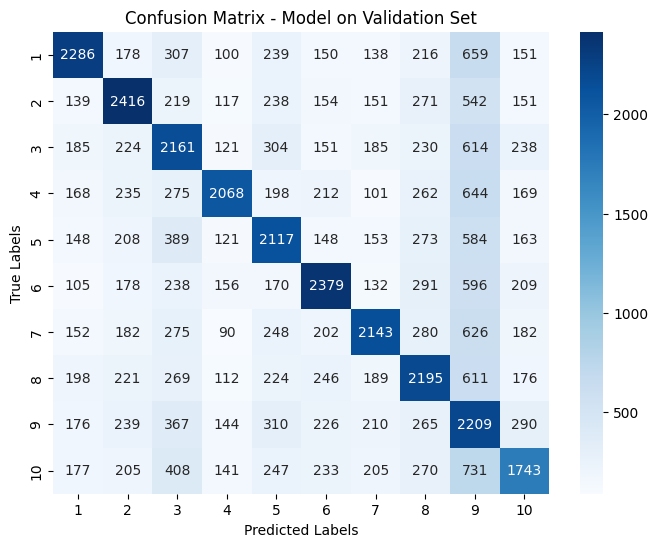

In [68]:
model.eval()

# To store the ground truth and predictions
all_labels = []
all_preds = []

# Step 2: Iterate over the validation DataLoader and collect predictions
with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in train_loader:
        # Move data to the device if using GPU
        inputs = inputs.to(device)  # Assuming device is defined
        labels = labels.to(device)
        
        # Forward pass: Get predictions
        outputs = model(inputs)
        
        # Get the predicted class (class with highest probability)
        _, predicted = torch.max(outputs, 1)
        
        # Store labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())  # Convert to CPU for compatibility with numpy
        all_preds.extend(predicted.cpu().numpy())

# Step 3: Calculate classification report and confusion matrix
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 11))
plt.title('Confusion Matrix - Model on Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.35      0.38      1106
           1       0.37      0.38      0.37      1100
           2       0.26      0.30      0.28      1104
           3       0.40      0.28      0.33      1084
           4       0.31      0.32      0.31      1077
           5       0.38      0.34      0.36      1114
           6       0.37      0.28      0.32      1096
           7       0.29      0.31      0.30      1111
           8       0.21      0.35      0.26      1109
           9       0.32      0.27      0.29      1090

    accuracy                           0.32     10991
   macro avg       0.33      0.32      0.32     10991
weighted avg       0.33      0.32      0.32     10991



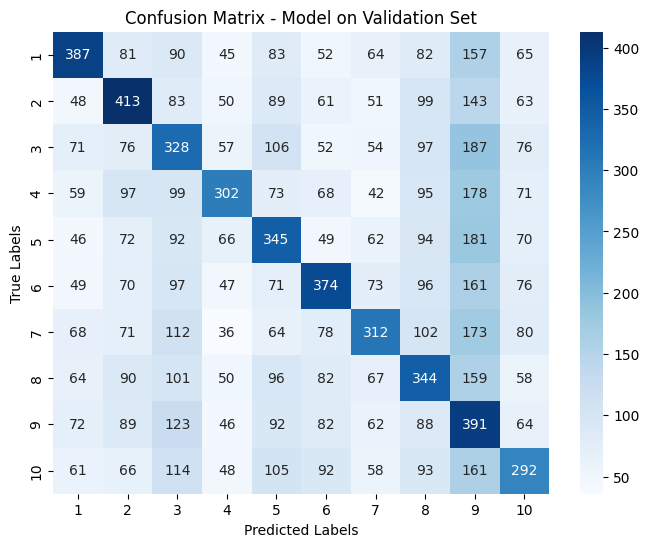

In [ ]:
model.eval()

# To store the ground truth and predictions
all_labels = []
all_preds = []

# Step 2: Iterate over the validation DataLoader and collect predictions
with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in val_loader:
        # Move data to the device if using GPU
        inputs = inputs.to(device)  # Assuming device is defined
        labels = labels.to(device)
        
        # Forward pass: Get predictions
        outputs = model(inputs)
        
        # Get the predicted class (class with highest probability)
        _, predicted = torch.max(outputs, 1)
        
        # Store labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())  # Convert to CPU for compatibility with numpy
        all_preds.extend(predicted.cpu().numpy())

# Step 3: Calculate classification report and confusion matrix
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 11))
plt.title('Confusion Matrix - Model on Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()